# Sensor Component Failure Prediction

## 1) Problem statement.

**Data:** Sensor Data

**Problem statement :**
- The system in focus is the Air Pressure system (APS) which generates pressurized air that are utilized in various functions in a truck, such as braking and gear changes. 
- `The datasets positive class corresponds to component failures for a specific component of the APS system`. 
- `The negative class corresponds to trucks with failures for components not related to the APS system`.

- The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false predictions.

|True class | Positive | Negative | |
| ----------- | ----------- |   |  |
|<b>Predicted class</b>||| |
| Positive      |   -       | cost_1  |    |
| Negative   | cost_2        |  | |


Cost 1 = 10 and Cost 2 = 500

- The total cost of a prediction model the sum of `Cost_1` multiplied by the number of Instances with type 1 failure and `Cost_2` with the number of instances with type 2 failure, resulting in a `Total_cost`. In this case `Cost_1` refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while `Cost_2` refer to the cost of missing a faulty truck, which may cause a breakdown. 
- `Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.`

- From the above problem statement we could observe that, we have to reduce false positives and false negatives. More importantly we have to **reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives.**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer

from imblearn.combine import SMOTETomek
%matplotlib inline

### Read Data 

In [2]:
raw_data  = pd.read_csv("dataset.csv",na_values="na")

In [3]:
raw_data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0.0,182.0,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,pos,453236,NaN,2926.0,NaN,0.0,0.0,0.0,0.0,222.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,pos,72504,NaN,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,pos,762958,NaN,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,pos,695994,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36188 entries, 0 to 36187
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 47.2+ MB


In [5]:
raw_data.shape

(36188, 171)

In [6]:
# define numerical & categorical columns
numeric_features = [feature for feature in raw_data.columns if raw_data[feature].dtype != 'O']
categorical_features = [feature for feature in raw_data.columns if raw_data[feature].dtype == 'O']

print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 170 numerical features : ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000'

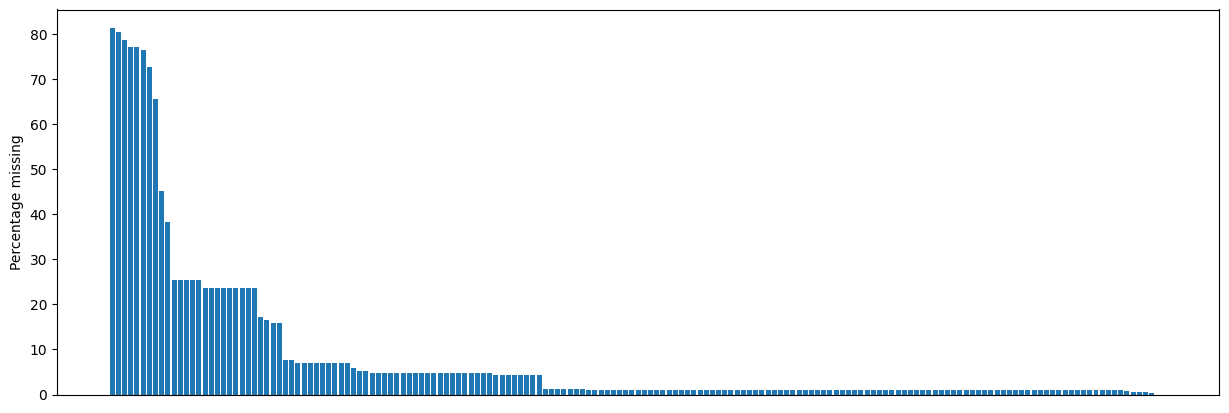

In [7]:
# Plotting Missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))

missing = raw_data.isna().sum().div(raw_data.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

In [8]:
dropcols = missing[missing[0]>50]
print(dropcols)
print(len(dropcols))

                0
br_000  81.410965
bq_000  80.501824
bp_000  78.794075
ab_000  77.086327
cr_000  77.086327
bo_000  76.533658
bn_000  72.761689
bm_000  65.518957
8


### Dropping Columns which has more than 50% of missing values.

In [9]:
raw_data.drop(list(dropcols.index), axis=1, inplace=True)

In [10]:
raw_data.shape

(36188, 163)

### Check the total percentage of missing values of full dataset after dropping columns with more than 20% of missing values

In [11]:
missing_values_count= raw_data.isnull().sum()
total_cells = np.product(raw_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print(f"Percentage of total missing cells in the data {(total_missing/total_cells) * 100}%")

Percentage of total missing cells in the data 5.0015901959840265%


### Visualization of unique values in Target variable

Positive: 1000, Negative: 35188


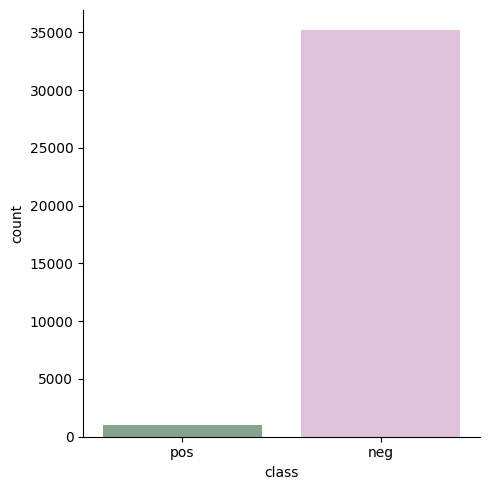

In [12]:
pos = raw_data[raw_data['class']=='pos'].shape[0]
neg = raw_data[raw_data['class']=='neg'].shape[0]
print("Positive: " + str(pos) + ", Negative: " + str(neg))
sns.catplot(data=raw_data, x="class", kind="count", hue="class", palette="cubehelix", alpha=.6, legend=False)
plt.show()

**Report**
- The target class is highly imbalanced
- Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class)
- If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model. 
- Hence we should handle imbalanced data with certain methods.

**How to handle Imbalance Data ?**

- Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.
- **SMOTE:** Synthetic Minority Oversampling Technique
- SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.
- Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques.
- It only duplicates the data and it won't add and new information. Hence we look at some different techniques.

In [13]:
df= raw_data

### Creating a function for model training and evaluation

In [14]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [15]:
# Create cost of the model as per data description
def total_cost(y_true, y_pred):
    '''
    This function takes y_true, y_predicted, and prints Total cost due to misclassification
   
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [16]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    cost_list=[]
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report

## Evaluate Model on Different experiments


In [17]:
# Splitting X and y for all Experiments
X= df.drop('class', axis=1)
y = df['class']

In [18]:
y= y.replace({'pos': 1, 'neg': 0})

### Scaling the data 

**Why Robust scaler and not Standard scaler?**
- Scaling the data using Robust scaler
- Since most of the independent variables are not normally distributed we cannot use Standardscaler

**Why Robust Scaler and not Minmax?** 
- because most of the feature has outliers. So Minmax will scale data according to Max values which is outlier.
- This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [19]:
# Fit with robust scaler for KNN best K-selection experminet
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

## Experiment: 1 = KNN Imputer for Null values

**Why KNN Imputer**?
- KNNImputer by scikit-learn is a widely used method to impute missing values. It is widely being observed as a replacement for traditional imputation techniques.
- KNNImputer helps to impute missing values present in the observations by finding the nearest neighbors with the Euclidean distance matrix.
- Here we Iterates through different K values and get accuracy and choose best K values.

#### Finding the optimal n_neighbour value for KNN imputer

Pipeline workflow

When the pipeline is executed, the following workflow occurs:

- The input data is passed to the first step, KNNImputer.
- The KNNImputer instance replaces missing values in the data using the KNN algorithm.
- The imputed data is then passed to the second step, LogisticRegression.
- The LogisticRegression instance trains a model on the imputed data and makes predictions.

By chaining these two steps together, the pipeline provides a simple way to handle missing values and then train a logistic regression model on the imputed data.

In [20]:
results=[]
# define imputer
#imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=5, n_jobs=-1)
    results.append(scores)
    
    print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))

n_neighbors= 1 || accuracy (0.6993)
n_neighbors= 3 || accuracy (0.7070)
n_neighbors= 5 || accuracy (0.6620)
n_neighbors= 7 || accuracy (0.6778)
n_neighbors= 9 || accuracy (0.6898)


**We can observe n_neighbors=3 able to produce highest accuracy**

### Pipeline for KNN imputer

In [21]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the KNN imputer with selected K-value
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('RobustScaler', RobustScaler())
])

In [22]:
X_knn =knn_pipeline.fit_transform(X)

## Handling Imbalanced data

**SMOTETomek is a powerful technique for handling class imbalance in machine learning!**

**SMOTETomek is a combination of two algorithms:**

- SMOTE (Synthetic Minority Over-sampling Technique): A popular oversampling method that generates new samples of the minority class by interpolating between existing minority class samples.
- Tomek Links: A method for removing noisy samples from the majority class by identifying samples that are close to the decision boundary.
**Here's how SMOTETomek works:**

**SMOTE:**

- Identify the minority class samples.
- Calculate the k-nearest neighbors (k-NN) for each minority class sample.
- Randomly select a minority class sample and one of its k-NN.
- Generate a new sample by interpolating between the selected minority class sample and its k-NN.
- Repeat steps 3-4 until the desired number of new minority class samples is generated.

**Tomek Links:**

- Identify the majority class samples that are close to the decision boundary.
- Remove these noisy samples from the majority class.
- By combining SMOTE and Tomek Links, SMOTETomek achieves two goals:

- Oversampling the minority class: SMOTE generates new minority class samples, increasing the size of the minority class and making the dataset more balanced.
- Removing noisy samples from the majority class: Tomek Links removes samples from the majority class that are close to the decision boundary, reducing the impact of noisy samples on the model's performance.

**The benefits of using SMOTETomek include:**

- Improved model performance on imbalanced datasets
- Reduced overfitting to the majority class
- Increased robustness to noisy samples
- However, it's essential to note that SMOTETomek can also have some limitations, such as:

- Increased computational time and resources required
- Risk of over-oversampling the minority class, leading to overfitting
- Potential loss of important information from the majority class

`fit_resample` is a method that fits the SMOTE algorithm to the data and resamples it to balance the classes.

In [23]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_knn, y)

C:\Users\prash\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


## Initialize Default Models in a dictionary

In [24]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

### Fit KNN imputed data for models in dictionary

In [25]:
report_knn = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9923
- F1 score: 0.9924
- Precision: 0.9880
- Recall: 0.9967
- Roc Auc Score: 0.9923
- COST: 12350.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9854
- F1 score: 0.9855
- Precision: 0.9825
- Recall: 0.9885
- Roc Auc Score: 0.9854
- COST: 41740.




C:\Users\prash\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Model performance for Training set
- Accuracy: 0.5849
- F1 score: 0.6903
- Precision: 0.5503
- Recall: 0.9260
- Roc Auc Score: 0.5852
- COST: 1249720.
----------------------------------
Model performance for Test set
- Accuracy: 0.5830
- F1 score: 0.6905
- Precision: 0.5499
- Recall: 0.9275
- Roc Auc Score: 0.5820
- COST: 308410.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9811
- F1 score: 0.9813
- Precision: 0.9697
- Recall: 0.9933
- Roc Auc Score: 0.9811
- COST: 103200.
----------------------------------
Model performance for Test set
- Accuracy: 0.9762
- F1 score: 0.9766
- Precision: 0.9626
- Recall: 0.9910
- Roc Auc Score: 0.9762
- COST: 34210.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9835
- F1 score: 0.9835
- Precision: 0.9810
- Recall: 0.9861
- Roc Auc Score: 0.9835
- COST: 200360.
----------------------------------
Model performance for Test set
- Accuracy: 0.9813
- F1 score: 0.9814
- Precision: 0.9783

C:\Users\prash\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier
Model performance for Training set
- Accuracy: 0.9745
- F1 score: 0.9745
- Precision: 0.9742
- Recall: 0.9747
- Roc Auc Score: 0.9745
- COST: 362230.
----------------------------------
Model performance for Test set
- Accuracy: 0.9737
- F1 score: 0.9737
- Precision: 0.9761
- Recall: 0.9713
- Roc Auc Score: 0.9737
- COST: 102670.




## Report for KNN Imputed data

In [26]:
report_knn

,Model Name,Cost
5,XGBClassifier,5400
6,CatBoosting Classifier,7510
0,Random Forest,12350
3,K-Neighbors Classifier,34210
1,Decision Tree,41740
4,Gradient Boosting,56040
7,AdaBoost Classifier,102670
2,Logistic Regression,308410


**Insights**
- For the Experiment 1: Knn imputer has XGBoost classifier as the best Model
- Proceeding with further experiments 

### Experiment: 2 = Simple Imputer with Strategy Median 

- SimpleImputer is a class in the `sklearn.impute` module that can be used to replace missing values in a dataset, using a variety of input strategies.
- Here we use SimpleImputer can also be used to impute multiple columns at once by passing in a list of column names. SimpleImputer will then replace missing values in all of the specified columns.

In [27]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the Simple imputer with strategy median
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [28]:
# Fit X with median_pipeline
X_median = median_pipeline.fit_transform(X)

In [29]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority')
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_median, y)

In [30]:
# Training the models
report_median = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9928
- F1 score: 0.9929
- Precision: 0.9893
- Recall: 0.9964
- Roc Auc Score: 0.9928
- COST: 13260.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9857
- F1 score: 0.9859
- Precision: 0.9820
- Recall: 0.9898
- Roc Auc Score: 0.9857
- COST: 37280.




C:\Users\prash\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Model performance for Training set
- Accuracy: 0.6222
- F1 score: 0.7227
- Precision: 0.5705
- Recall: 0.9857
- Roc Auc Score: 0.6225
- COST: 408030.
----------------------------------
Model performance for Test set
- Accuracy: 0.6245
- F1 score: 0.7244
- Precision: 0.5733
- Recall: 0.9835
- Roc Auc Score: 0.6232
- COST: 109530.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9809
- F1 score: 0.9811
- Precision: 0.9690
- Recall: 0.9935
- Roc Auc Score: 0.9809
- COST: 99400.
----------------------------------
Model performance for Test set
- Accuracy: 0.9736
- F1 score: 0.9740
- Precision: 0.9596
- Recall: 0.9889
- Roc Auc Score: 0.9735
- COST: 41930.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9836
- F1 score: 0.9836
- Precision: 0.9813
- Recall: 0.9859
- Roc Auc Score: 0.9836
- COST: 202780.
----------------------------------
Model performance for Test set
- Accuracy: 0.9823
- F1 score: 0.9824
- Precision: 0.9795
-

C:\Users\prash\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier
Model performance for Training set
- Accuracy: 0.9737
- F1 score: 0.9737
- Precision: 0.9730
- Recall: 0.9745
- Roc Auc Score: 0.9737
- COST: 365090.
----------------------------------
Model performance for Test set
- Accuracy: 0.9719
- F1 score: 0.9720
- Precision: 0.9722
- Recall: 0.9719
- Roc Auc Score: 0.9719
- COST: 100960.




## Report for Simple Imputer with median strategy

In [31]:
report_median

,Model Name,Cost
5,XGBClassifier,1440
6,CatBoosting Classifier,10070
0,Random Forest,13260
1,Decision Tree,37280
3,K-Neighbors Classifier,41930
4,Gradient Boosting,53450
7,AdaBoost Classifier,100960
2,Logistic Regression,109530


**Insights**
- For the Experiment 2: Simple imputer with median strategy has Catboost classifier as the best Model
- Proceeding with further experiments 

### Experiment: 3 = MICE for Imputing Null values

- MICE stands for Multivariate Imputation By Chained Equations algorithm
- This technique by which we can effortlessly impute missing values in a dataset by looking at data from other columns and trying to estimate the best prediction for each missing value.
- `ImputationKernel` Creates a kernel dataset. This dataset can perform MICE on itself, and impute new data from models obtained during MICE.

In [32]:
import miceforest as mf

X_mice = X.copy()
kernel = mf.ImputationKernel(
  X_mice,
  save_all_iterations=True,
  random_state=1989
)# Run the MICE algorithm for 3 iterations kernel.mice(3)

In [33]:
X_mice = kernel.complete_data()

In [34]:
# fit robust scaler
mice_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

In [35]:
# Fit X with Mice imputer 
X_mice= mice_pipeline.fit_transform(X_mice)

In [36]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mice, y)

C:\Users\prash\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [37]:
# Training the models
report_mice = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9896
- F1 score: 0.9895
- Precision: 0.9835
- Recall: 0.9957
- Roc Auc Score: 0.9897
- COST: 16160.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9824
- F1 score: 0.9823
- Precision: 0.9769
- Recall: 0.9877
- Roc Auc Score: 0.9824
- COST: 44120.




C:\Users\prash\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Model performance for Training set
- Accuracy: 0.6045
- F1 score: 0.7074
- Precision: 0.5623
- Recall: 0.9535
- Roc Auc Score: 0.6036
- COST: 862260.
----------------------------------
Model performance for Test set
- Accuracy: 0.6008
- F1 score: 0.7025
- Precision: 0.5563
- Recall: 0.9529
- Roc Auc Score: 0.6044
- COST: 216220.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9796
- F1 score: 0.9799
- Precision: 0.9684
- Recall: 0.9917
- Roc Auc Score: 0.9796
- COST: 126110.
----------------------------------
Model performance for Test set
- Accuracy: 0.9662
- F1 score: 0.9665
- Precision: 0.9471
- Recall: 0.9867
- Roc Auc Score: 0.9664
- COST: 49820.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9858
- F1 score: 0.9859
- Precision: 0.9835
- Recall: 0.9882
- Roc Auc Score: 0.9858
- COST: 170160.
----------------------------------
Model performance for Test set
- Accuracy: 0.9802
- F1 score: 0.9802
- Precision: 0.9740


C:\Users\prash\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier
Model performance for Training set
- Accuracy: 0.9773
- F1 score: 0.9774
- Precision: 0.9767
- Recall: 0.9781
- Roc Auc Score: 0.9773
- COST: 314570.
----------------------------------
Model performance for Test set
- Accuracy: 0.9746
- F1 score: 0.9744
- Precision: 0.9712
- Recall: 0.9777
- Roc Auc Score: 0.9746
- COST: 79510.




## Report for MICE Imputer algorithm

In [38]:
report_mice

,Model Name,Cost
5,XGBClassifier,5210
6,CatBoosting Classifier,10350
0,Random Forest,16160
1,Decision Tree,44120
4,Gradient Boosting,48830
3,K-Neighbors Classifier,49820
7,AdaBoost Classifier,79510
2,Logistic Regression,216220


**Insights**
- For the Experiment 3: Mice imputer has XGBoost classifier as the best Model
- Proceeding with further experiments 

### Experiment: 4 = Simple Imputer with Strategy Constant 

- Another strategy which can be used is replacing missing values with a fixed (constant) value.
- To do this, specify “constant” for strategy and specify the fill value using the fill_value parameter

In [39]:
# Create a pipeline with simple imputer with strategy constant and fill value 0
constant_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [40]:
X_const =constant_pipeline.fit_transform(X)

In [41]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

C:\Users\prash\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [42]:
# training the models
report_const = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9927
- F1 score: 0.9928
- Precision: 0.9894
- Recall: 0.9962
- Roc Auc Score: 0.9927
- COST: 14250.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9873
- F1 score: 0.9874
- Precision: 0.9821
- Recall: 0.9927
- Roc Auc Score: 0.9873
- COST: 26770.




C:\Users\prash\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Model performance for Training set
- Accuracy: 0.6718
- F1 score: 0.7487
- Precision: 0.6063
- Recall: 0.9784
- Roc Auc Score: 0.6720
- COST: 481090.
----------------------------------
Model performance for Test set
- Accuracy: 0.6711
- F1 score: 0.7493
- Precision: 0.6065
- Recall: 0.9800
- Roc Auc Score: 0.6702
- COST: 115220.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9803
- F1 score: 0.9806
- Precision: 0.9683
- Recall: 0.9932
- Roc Auc Score: 0.9803
- COST: 105110.
----------------------------------
Model performance for Test set
- Accuracy: 0.9750
- F1 score: 0.9754
- Precision: 0.9626
- Recall: 0.9885
- Roc Auc Score: 0.9749
- COST: 43200.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9827
- F1 score: 0.9827
- Precision: 0.9804
- Recall: 0.9851
- Roc Auc Score: 0.9827
- COST: 214530.
----------------------------------
Model performance for Test set
- Accuracy: 0.9801
- F1 score: 0.9802
- Precision: 0.9774


C:\Users\prash\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier
Model performance for Training set
- Accuracy: 0.9752
- F1 score: 0.9752
- Precision: 0.9727
- Recall: 0.9778
- Roc Auc Score: 0.9752
- COST: 319200.
----------------------------------
Model performance for Test set
- Accuracy: 0.9752
- F1 score: 0.9753
- Precision: 0.9732
- Recall: 0.9774
- Roc Auc Score: 0.9752
- COST: 81390.




## Report for Simple Imputer with Constant strategy

In [43]:
report_const

,Model Name,Cost
5,XGBClassifier,2410
6,CatBoosting Classifier,5030
0,Random Forest,14250
1,Decision Tree,26770
3,K-Neighbors Classifier,43200
4,Gradient Boosting,61100
7,AdaBoost Classifier,81390
2,Logistic Regression,115220


**Insights**
- For the Experiment 4: Simple imputer with constant strategy has XGBoost classifier as the best Model
- Proceeding with further experiments 

## Experiment: 5 = Simple Imputer with Strategy Mean 

- Another strategy which can be used is replacing missing values with mean
- Here we replace the missing values with the mean of the column

In [44]:
# Create a pipeline with Simple imputer with strategy mean
mean_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('RobustScaler', RobustScaler())
])

In [45]:
X_mean = mean_pipeline.fit_transform(X)

In [46]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority' , n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mean, y)

C:\Users\prash\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [47]:
# Training all models
report_mean = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9931
- F1 score: 0.9931
- Precision: 0.9886
- Recall: 0.9977
- Roc Auc Score: 0.9931
- COST: 8810.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9877
- F1 score: 0.9878
- Precision: 0.9842
- Recall: 0.9915
- Roc Auc Score: 0.9877
- COST: 31120.




C:\Users\prash\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Model performance for Training set
- Accuracy: 0.6637
- F1 score: 0.7318
- Precision: 0.6085
- Recall: 0.9178
- Roc Auc Score: 0.6637
- COST: 1318200.
----------------------------------
Model performance for Test set
- Accuracy: 0.6610
- F1 score: 0.7299
- Precision: 0.6068
- Recall: 0.9157
- Roc Auc Score: 0.6608
- COST: 337650.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9819
- F1 score: 0.9821
- Precision: 0.9722
- Recall: 0.9922
- Roc Auc Score: 0.9819
- COST: 117460.
----------------------------------
Model performance for Test set
- Accuracy: 0.9728
- F1 score: 0.9731
- Precision: 0.9606
- Recall: 0.9860
- Roc Auc Score: 0.9728
- COST: 51840.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9862
- F1 score: 0.9862
- Precision: 0.9834
- Recall: 0.9891
- Roc Auc Score: 0.9862
- COST: 158170.
----------------------------------
Model performance for Test set
- Accuracy: 0.9827
- F1 score: 0.9828
- Precision: 0.9793

C:\Users\prash\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier
Model performance for Training set
- Accuracy: 0.9770
- F1 score: 0.9769
- Precision: 0.9772
- Recall: 0.9767
- Roc Auc Score: 0.9770
- COST: 333880.
----------------------------------
Model performance for Test set
- Accuracy: 0.9775
- F1 score: 0.9775
- Precision: 0.9780
- Recall: 0.9769
- Roc Auc Score: 0.9775
- COST: 82540.




### Report for Simple imputer with strategy mean

In [48]:
report_mean

,Model Name,Cost
5,XGBClassifier,2900
6,CatBoosting Classifier,5980
0,Random Forest,8810
1,Decision Tree,31120
4,Gradient Boosting,49960
3,K-Neighbors Classifier,51840
7,AdaBoost Classifier,82540
2,Logistic Regression,337650


### Experiment: 5 = Principle component analysis with imputing mean

- Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables! 
- As the dataset has 164 columns we can try PCA and check our metrics Cost

In [49]:
from sklearn.decomposition import PCA

In [50]:
pca_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [51]:
X_pca = pca_pipeline.fit_transform(X)

In [52]:

# Assuming X_pca is your dataset
n_samples, n_features = X_pca.shape
var_ratio = {}

for n in range(2, 150):
    if n > min(n_samples, n_features):
        break
    pc = PCA(n_components=n)
    df_pca = pc.fit(X_pca)
    var_ratio[n] = sum(df_pca.explained_variance_ratio_)

**Variance Plot**

<Axes: >

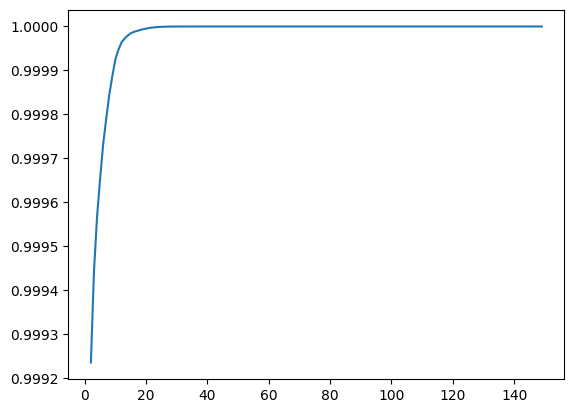

In [53]:
# plotting variance ratio
pd.Series(var_ratio).plot()

**Kneed algorithm to find the elbow point**

<Figure size 500x500 with 0 Axes>

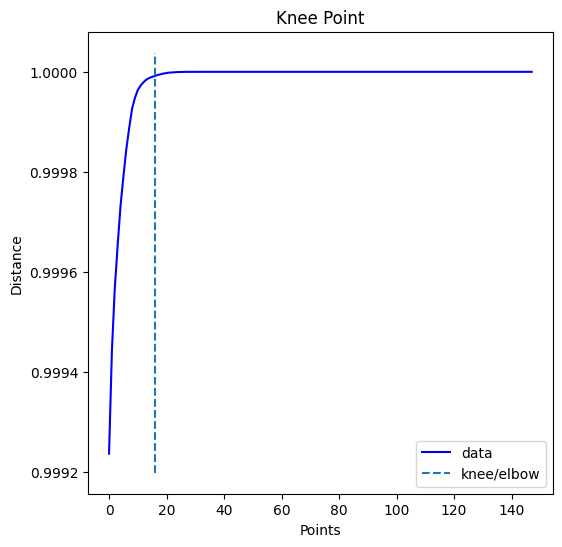

Knee Locator k = 18


In [54]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)

In [55]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=18,random_state=42).fit(X_res)

reduced=pca_final.fit_transform(X_pca)

In [56]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(reduced, y)

C:\Users\prash\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [57]:
# Training all models
report_pca = evaluate_models(X_res,y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9987
- F1 score: 0.9987
- Precision: 1.0000
- Recall: 0.9975
- Roc Auc Score: 0.9987
- COST: 34510.
----------------------------------
Model performance for Test set
- Accuracy: 0.9828
- F1 score: 0.9831
- Precision: 0.9771
- Recall: 0.9892
- Roc Auc Score: 0.9828
- COST: 39640.


Decision Tree
Model performance for Training set
- Accuracy: 0.9988
- F1 score: 0.9988
- Precision: 1.0000
- Recall: 0.9975
- Roc Auc Score: 0.9988
- COST: 34500.
----------------------------------
Model performance for Test set
- Accuracy: 0.9725
- F1 score: 0.9729
- Precision: 0.9683
- Recall: 0.9775
- Roc Auc Score: 0.9724
- COST: 81760.




C:\Users\prash\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Model performance for Training set
- Accuracy: 0.8772
- F1 score: 0.8668
- Precision: 0.9440
- Recall: 0.8013
- Roc Auc Score: 0.8770
- COST: 2785260.
----------------------------------
Model performance for Test set
- Accuracy: 0.8794
- F1 score: 0.8709
- Precision: 0.9477
- Recall: 0.8056
- Roc Auc Score: 0.8801
- COST: 689640.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9729
- F1 score: 0.9730
- Precision: 0.9661
- Recall: 0.9799
- Roc Auc Score: 0.9729
- COST: 289580.
----------------------------------
Model performance for Test set
- Accuracy: 0.9650
- F1 score: 0.9657
- Precision: 0.9555
- Recall: 0.9761
- Roc Auc Score: 0.9648
- COST: 87710.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9415
- F1 score: 0.9413
- Precision: 0.9434
- Recall: 0.9392
- Roc Auc Score: 0.9415
- COST: 864230.
----------------------------------
Model performance for Test set
- Accuracy: 0.9384
- F1 score: 0.9389
- Precision: 0.9405

C:\Users\prash\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier
Model performance for Training set
- Accuracy: 0.9193
- F1 score: 0.9186
- Precision: 0.9251
- Recall: 0.9121
- Roc Auc Score: 0.9193
- COST: 1246100.
----------------------------------
Model performance for Test set
- Accuracy: 0.9191
- F1 score: 0.9194
- Precision: 0.9255
- Recall: 0.9133
- Roc Auc Score: 0.9192
- COST: 311190.




### Report for PCA and Mean imputed data


In [58]:
report_pca

,Model Name,Cost
0,Random Forest,39640
5,XGBClassifier,56410
6,CatBoosting Classifier,69700
1,Decision Tree,81760
3,K-Neighbors Classifier,87710
4,Gradient Boosting,225690
7,AdaBoost Classifier,311190
2,Logistic Regression,689640


## Final Model

In [66]:
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Model","Imputation_method","Total_cost"]
pt.add_row(["XGBClassifier","Simple Imputer-Constant","2410"])
pt.add_row(["XGBClassifier","Simple Imputer-Mean","2900"])
pt.add_row(["XGBClassifier","Simple Imputer Median","1440"])
pt.add_row(["XGBClassifier","Mice","5210"])
pt.add_row(["XGBClassifier","Knn-Imputer","5400"])
pt.add_row(["Random Forest","PCA","39640"])
print(pt)

+---------------+-------------------------+------------+
|     Model     |    Imputation_method    | Total_cost |
+---------------+-------------------------+------------+
| XGBClassifier | Simple Imputer-Constant |    2410    |
| XGBClassifier |   Simple Imputer-Mean   |    2900    |
| XGBClassifier |  Simple Imputer Median  |    1440    |
| XGBClassifier |           Mice          |    5210    |
| XGBClassifier |       Knn-Imputer       |    5400    |
| Random Forest |           PCA           |   39640    |
+---------------+-------------------------+------------+


**Report**
- From the final report we can see than XGBClassifier with Simple imputer with median has performed the best with cost of 1440

### Fitting the Final model and get reports

In [67]:
final_model = XGBClassifier()

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_median, y)

C:\Users\prash\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [69]:
print("Final XGBoost Classifier Accuracy Score (Train) :", final_model.score(X_train,y_train))
print("Final XGBoost Classifier Accuracy Score (Test) :", accuracy_score(y_pred,y_test))

Final XGBoost Classifier Accuracy Score (Train) : 0.9999821813581369
Final XGBoost Classifier Accuracy Score (Test) : 0.996721545150025


In [70]:
print("Final XGBoost Classifier Cost Metric(Test) :",total_cost(y_test, y_pred))

Final XGBoost Classifier Cost Metric(Test) : 1440


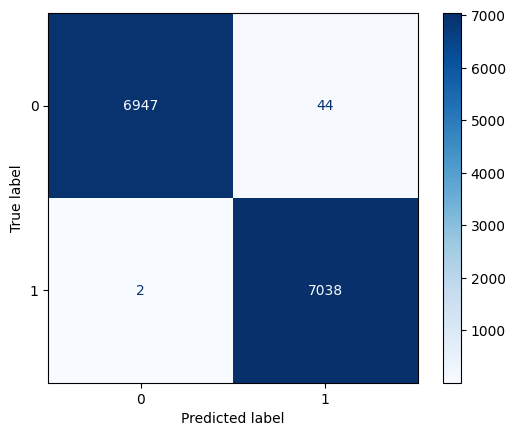

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Make predictions
y_pred = final_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap='Blues', values_format='d')


## The best Model is XGBClassifier Classifier with 99.67% accuracy and cost of 1440

In the context of this confusion matrix for a truck repair prediction model, the costs associated with False Positives (FP) and False Negatives (FN) can be evaluated as follows:

Breakdown of the Costs:

`False Positives (Cost_1):`

In the confusion matrix, we see 44 false positives. These represent cases where the model predicted that a truck needed repairs (positive), but in reality, it didn't (negative).
Cost_1 is defined as $10 per false positive, which represents the cost of an unnecessary check by a mechanic.
The total cost for false positives would be:

**Total Cost of False Positives=44×10=$440**

`False Negatives (Cost_2):`

In the confusion matrix, we have 2 false negatives. These represent cases where the model predicted that a truck did not need repairs (negative), but it actually did (positive). This could lead to a costly breakdown.
Cost_2 is defined as $500 per false negative, representing the cost of missing a faulty truck.
The total cost for false negatives would be:

**Total Cost of False Negatives = 2×500 =$1000**

Total Cost:
The overall cost for the model’s errors (false positives and false negatives) is:
Total Cost=440+1000=$1440

Implications:
Even though there are more false positives (44 instances), the cost of false negatives is much higher ($500 vs. $10), making false negatives more impactful in terms of cost.
In this case, minimizing false negatives (trucks that need repair but are missed) should be a priority because their associated cost is significantly higher, potentially leading to dangerous truck breakdowns.